In [114]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from skimage import io
from scipy.signal import find_peaks

def show_image(img, cmap=None, name=None, size=None):
    if size is not None:
        plt.figure(figsize=size)
    else:
        plt.figure(figsize=(3,3))
    if cmap is not None:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img)
    plt.axis('off')
    if name is not None:
        plt.title(name)
    plt.show()

Read image and convert to grayscale

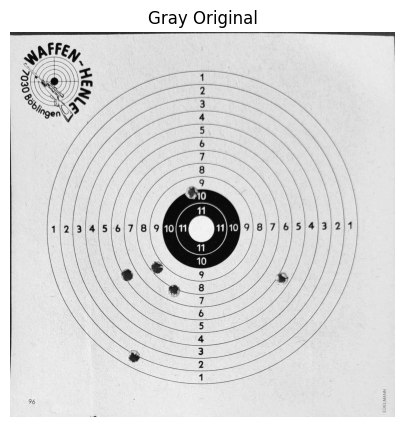

In [115]:

image = io.imread(f'resources/aligned/shot_3.jpg')
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
show_image(gray_image, cmap="gray", size=(5,5), name="Gray Original")

Filter image and find the black circle in the center

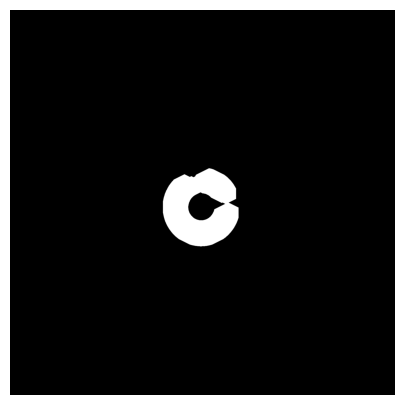

In [116]:
filtered_image = gray_image.copy()
filtered_image = cv2.GaussianBlur(filtered_image, (5, 5), 0)
border_width=50
filtered_image[:border_width, :] = 255
filtered_image[-border_width:, :] = 255
filtered_image[:, :border_width] = 255
filtered_image[:, -border_width:] = 255
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
cv2.morphologyEx(filtered_image, cv2.MORPH_OPEN, kernel, filtered_image, iterations=3)
cv2.morphologyEx(filtered_image, cv2.MORPH_CLOSE, kernel, filtered_image, iterations=25)
threshold = 80
filtered_image[filtered_image < threshold] = 0
filtered_image[filtered_image >= threshold] = 255
filtered_image = cv2.bitwise_not(filtered_image)
show_image(filtered_image, cmap="gray", size=(5,5))

Search biggest contour to find center of the target

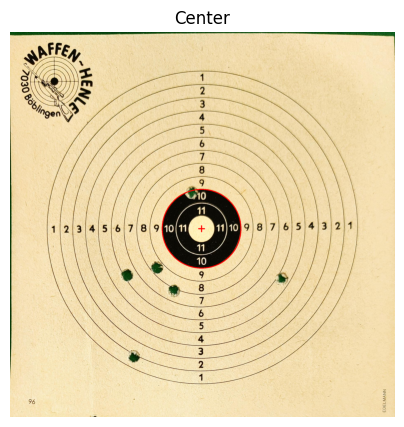

In [117]:
contours, _ = cv2.findContours(filtered_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
biggest_cntr = None
biggest_radius = 0
marked = image.copy()
for contour in contours:
    radius = cv2.minEnclosingCircle(contour)[1]
    if radius > biggest_radius:
        biggest_radius = radius
        biggest_cntr = contour
# Zentrum der größten Kontur über minimal umschließenden Kreis
(centerX, centerY), biggest_radius = cv2.minEnclosingCircle(biggest_cntr)
centerX = int(centerX)
centerY = int(centerY)
cv2.drawMarker(marked, (centerX, centerY), (255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=30, thickness=3, line_type=cv2.LINE_AA)
cv2.circle(marked, (centerX, centerY), int(biggest_radius), (255, 0, 0), 3)
show_image(marked, size=(5,5), name="Center")

Generate sobel

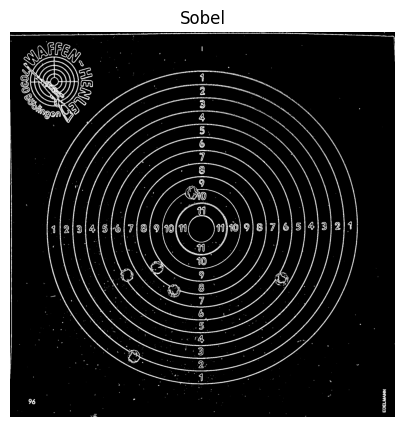

In [118]:
sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
sobel = cv2.magnitude(sobelx, sobely)

# CV2 sobel ist deutlich schneller als selber geschriebener
sobel = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
threshold = 40
sobel[sobel < threshold] = 0
sobel[sobel >= threshold] = 255

show_image(sobel, cmap="gray", size=(5,5), name="Sobel")

Use modified hough transform to find circles and store corresponding points in summed array.

Used peaks in hough space to fit points to ellipses.

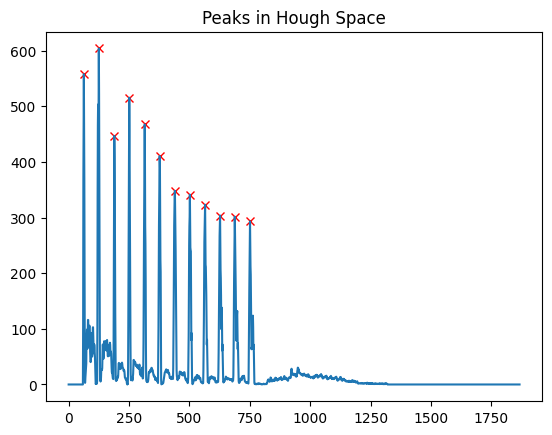

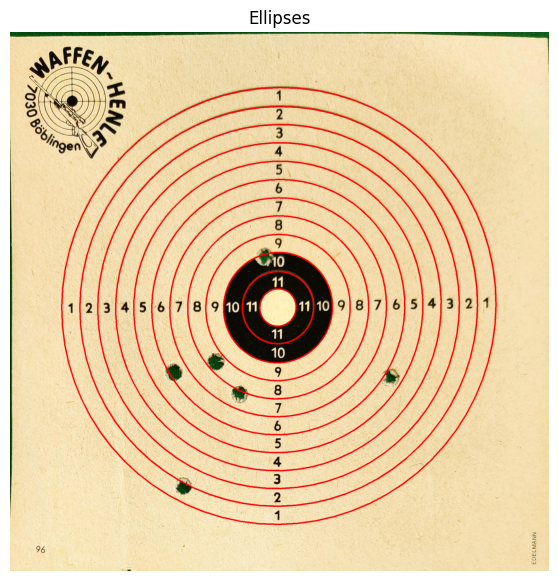

In [119]:
def hough_circles_around_center(image, fix, plot_peaks=False):
    thisdict = {}
    height, width = image.shape
    acc = np.zeros(width)
    x_f, y_f = fix
    for x in range(0, width):
        for y in range(0, height):
            if image[y, x] > 0:
                radius = np.floor(
                    np.sqrt((x_f - x)**2 + (y_f - y)**2)).astype("int")
                if not radius in thisdict:
                    thisdict[radius]=[]
                acc[radius] = acc[radius] + 1
                thisdict[radius].append((x,y))

    # Kleiner Radius = weniger Punkte auf dem Kreis
    acc = acc / ((np.arange(len(acc))+1))
    acc = acc * 100
    max = np.max(acc)
    peaks, _ = find_peaks(acc, prominence=1, distance=40, height=0.3*max)

    if plot_peaks:
        plt.plot(peaks,  acc[peaks], "xr")
        plt.title('Peaks in Hough Space')
        plt.plot(acc)
        plt.show()

    summed={}
    for peak in peaks:
        if not peak in summed:
            summed[peak]=[]
        for r in range(-8,8):
            if (peak+r) in thisdict:
                summed[peak].extend(thisdict[peak+r])


    indices = np.nonzero(acc)
    indices = np.array(indices).astype("int").flatten()
    return (peaks).astype("int"),summed

circles,summed = hough_circles_around_center(sobel, (centerX, centerY), True)


marked = image.copy()
ellipses = []
for elem in summed.values():
    ellipse = cv2.fitEllipse(np.array(elem))
    ellipses.append(ellipse)
    cv2.ellipse(marked, ellipse, (255, 0, 0), 4)
show_image(marked,size=(7,7), name="Ellipses")

Convert image to hsv and extract a background mask for the shots

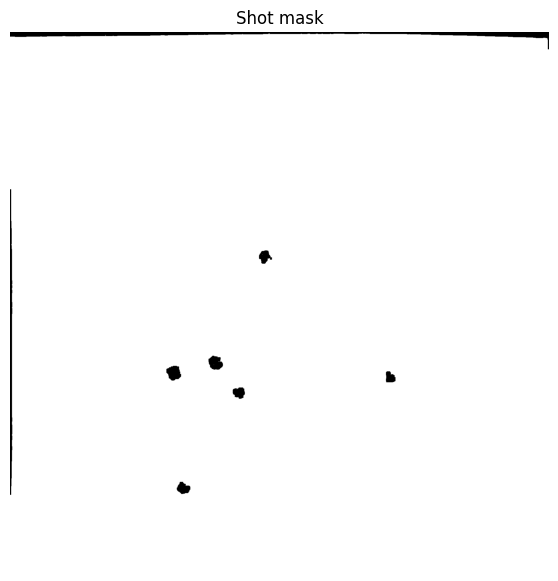

In [120]:
# convert the BGR image to HSV colour space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
# set the lower and upper bounds for the green hue
lower_green = np.array([20, 80, 20])
upper_green = np.array([90, 255, 255])
# create a mask for green colour using inRange function
mask = cv2.inRange(hsv, lower_green, upper_green)
# perform bitwise and on the original image arrays using the mask
masked_shots = cv2.bitwise_and(image, image, mask=mask)
masked_shots = cv2.cvtColor(masked_shots, cv2.COLOR_BGR2GRAY)
threshold = 10
masked_shots[masked_shots < threshold] = 0
masked_shots[masked_shots >= threshold] = 255

masked_shots = cv2.bitwise_not(masked_shots)
# dilate the masked image to fill in holes
kernel = np.ones((3, 3), np.uint8)
masked_shots = cv2.dilate(masked_shots, kernel, iterations=3)
masked_shots = cv2.erode(masked_shots, kernel, iterations=3)
show_image(masked_shots, cmap='gray', size=(7, 7), name="Shot mask")

Use blob detector to find blobs in mask

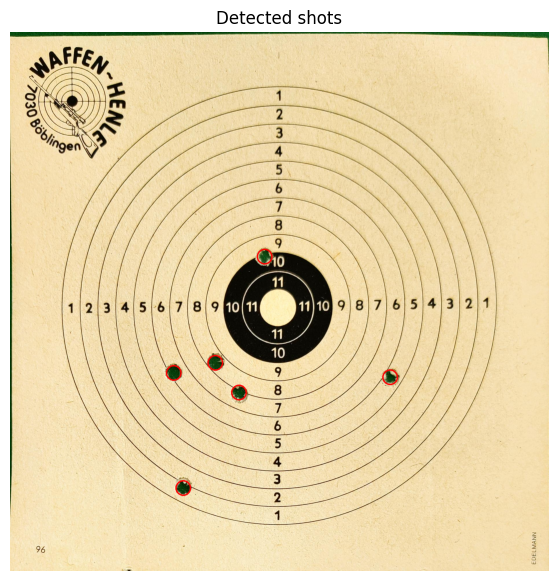

In [121]:
params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.minArea = 700
params.maxArea = 500000
params.filterByCircularity = False
params.filterByConvexity = False
params.filterByInertia = False
detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect(masked_shots)
marked = image.copy()

for keypoint in keypoints:
    x = int(keypoint.pt[0])
    y = int(keypoint.pt[1])
    cv2.circle(marked, (x, y), 25, (255, 0, 0), 3)
show_image(marked, size=(7, 7), name="Detected shots")

Find the score of all hits. Find the the point on the circle that is closest to the center of the elipse. Then we check if that point is within the elipse

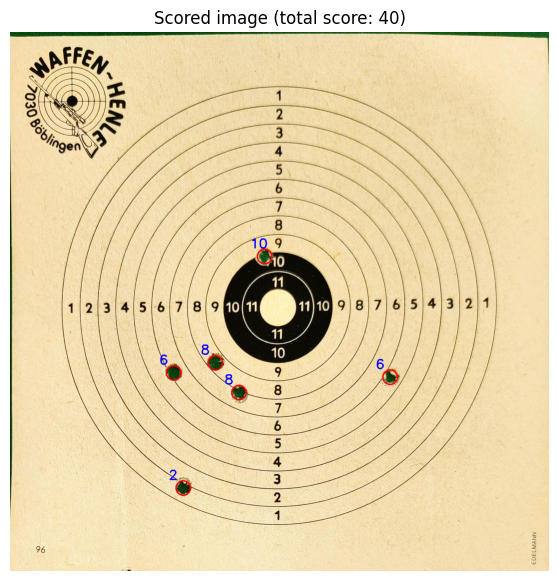

Total score:  40
Number of shots:  6
Hit:  6
Misses:  0
Accuracy:  100.00 %


In [122]:
def is_point_inside_ellipse(x, y, cx, cy, a, b, theta):
    # Convert angle to radians
    theta = np.radians(theta)

    # Calculate rotated coordinates
    x_rot = (x - cx) * np.cos(theta) + (y - cy) * np.sin(theta)
    y_rot = (y - cy) * np.cos(theta) - (x - cx) * np.sin(theta)

    # Check if point is inside ellipse
    return (x_rot / a)**2 + (y_rot / b)**2 <= 1

def check_circle_in_ellipse(ellipse_center, ellipse_major_axis, ellipse_minor_axis, angle, circle_center, circle_radius):
    # Calculate distance between centers
    dx = circle_center[0] - ellipse_center[0] 
    dy = circle_center[1] - ellipse_center[1] 
    distance = np.sqrt(dx**2 + dy**2)
    if(distance < circle_radius):
        print("Circle is inside ellipse smoll radius")
        return True    
    x = dx /distance*(distance-circle_radius)+ellipse_center[0]
    y = dy /distance*(distance-circle_radius)+ellipse_center[1]
    return is_point_inside_ellipse(x, y, ellipse_center[0], ellipse_center[1], ellipse_major_axis, ellipse_minor_axis, angle)

def calculate_score(image, keypoints):   
    total_score = 0
    hit = 0
    misses = 0 
    for keypoint in keypoints:
        score = 0
        x = int(keypoint.pt[0])
        y = int(keypoint.pt[1])
        for i, ellipse in enumerate(ellipses):
            major_axis = ellipse[1][0] / 2
            minor_axis = ellipse[1][1] / 2
            center = ellipse[0]
            angle = ellipse[2]
            if(check_circle_in_ellipse(center, major_axis, minor_axis, angle, keypoint.pt, 25)):
                score = len(ellipses) - i
                break
        cv2.putText(image, str(score), (x-50, y-30), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)       
        cv2.circle(marked, (x, y), 25, (255, 0, 0), 3)
        total_score += score
        hit += 1 if score > 0 else 0
        misses += 1 if score == 0 else 0
    return total_score, hit, misses     

marked = image.copy()
num_shots = len(keypoints)
total_score, hit, misses = calculate_score(marked, keypoints)
show_image(marked, size=(7, 7), name="Scored image (total score: " + str(total_score) + ")")
print("Total score: ", total_score)
print("Number of shots: ", num_shots)
print("Hit: ", hit)
print("Misses: ", misses)
print("Accuracy: ", "{:.2f}".format(hit / num_shots * 100), "%")

Auswertung aller Bilder

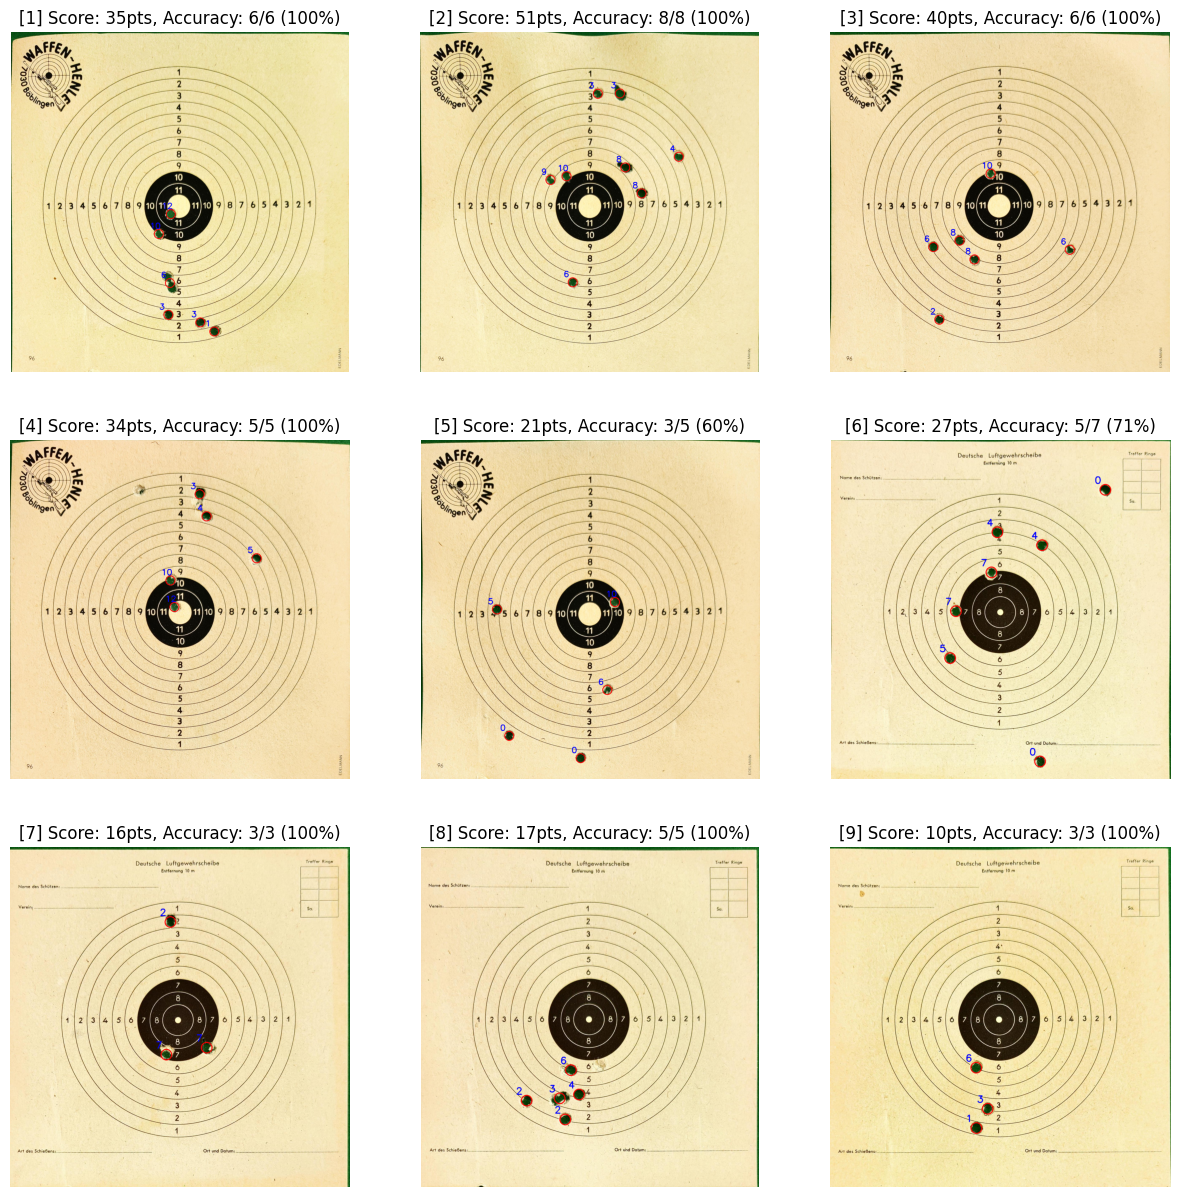

In [123]:
num_shots = 9

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for shot_id in range(1,num_shots+1):
    image = io.imread(f'resources/aligned/shot_{shot_id}.jpg')
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    filtered_image = gray_image.copy()
    filtered_image = cv2.GaussianBlur(filtered_image, (5, 5), 0)
    border_width=50
    filtered_image[:border_width, :] = 255
    filtered_image[-border_width:, :] = 255
    filtered_image[:, :border_width] = 255
    filtered_image[:, -border_width:] = 255
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    cv2.morphologyEx(filtered_image, cv2.MORPH_OPEN, kernel, filtered_image, iterations=3)
    cv2.morphologyEx(filtered_image, cv2.MORPH_CLOSE, kernel, filtered_image, iterations=25)
    threshold = 80
    filtered_image[filtered_image < threshold] = 0
    filtered_image[filtered_image >= threshold] = 255
    filtered_image = cv2.bitwise_not(filtered_image)  

    contours, _ = cv2.findContours(filtered_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    biggest_cntr = None
    biggest_radius = 0
    marked = image.copy()
    for contour in contours:
        radius = cv2.minEnclosingCircle(contour)[1]
        if radius > biggest_radius:
            biggest_radius = radius
            biggest_cntr = contour
    # Zentrum der größten Kontur über minimal umschließenden Kreis
    (centerX, centerY), biggest_radius = cv2.minEnclosingCircle(biggest_cntr)
    centerX = int(centerX)
    centerY = int(centerY)

    sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
    sobel = cv2.magnitude(sobelx, sobely)

    # CV2 sobel ist deutlich schneller als selber geschriebener
    sobel = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    threshold = 40
    sobel[sobel < threshold] = 0
    sobel[sobel >= threshold] = 255

    circles,summed = hough_circles_around_center(sobel, (centerX, centerY), False)


    ellipses = []
    for elem in summed.values():
        ellipse = cv2.fitEllipse(np.array(elem))
        ellipses.append(ellipse)
    
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_green = np.array([20, 80, 20])
    upper_green = np.array([90, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)
    masked_shots = cv2.bitwise_and(image, image, mask=mask)
    masked_shots = cv2.cvtColor(masked_shots, cv2.COLOR_BGR2GRAY)
    threshold = 10
    masked_shots[masked_shots < threshold] = 0
    masked_shots[masked_shots >= threshold] = 255

    masked_shots = cv2.bitwise_not(masked_shots)
    kernel = np.ones((3, 3), np.uint8)
    masked_shots = cv2.dilate(masked_shots, kernel, iterations=3)
    masked_shots = cv2.erode(masked_shots, kernel, iterations=3)

    params = cv2.SimpleBlobDetector_Params()
    params.filterByArea = True
    params.minArea = 700
    params.maxArea = 500000
    params.filterByCircularity = False
    params.filterByConvexity = False
    params.filterByInertia = False
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(masked_shots)

    marked = image.copy()
    num_shots = len(keypoints)
    total_score, hit, misses = calculate_score(marked, keypoints)

    # plot the gray_image
    axes[(shot_id-1)//3, (shot_id-1)%3].imshow(marked)
    axes[(shot_id-1)//3, (shot_id-1)%3].set_title(f'[{shot_id}] Score: {total_score}pts, Accuracy: {hit}/{num_shots} ({hit / num_shots * 100:.0f}%)')
    axes[(shot_id-1)//3, (shot_id-1)%3].axis('off')